<a href="https://colab.research.google.com/github/FilippMaksimov/AdaptiveSystems/blob/main/MaksimovF_Autopilot_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Параметры модели
T0_nom, T1_nom, T2_nom, K_nom = 4.0, 1.0, 6.0, 0.25
T0_real, T1_real, T2_real, K_real = 2.0, 1.0, 6.0, 0.5

# Параметры ПИД-регулятора
Kp, Ki, Kd = 2.455, 0.093, 2.458

# Параметры адаптации (стабилизированные)
gamma = 0.01  # Значительно уменьшен
nu0 = 0.001

# Время моделирования
dt = 0.01
t = np.arange(0, 100, dt)
n = len(t)

Класс судна (модель Номото)

In [ ]:
class Ship:
    def __init__(self, T0, T1, T2, K):
        self.T0, self.T1, self.T2, self.K = T0, T1, T2, K
        self.omega = 0.0
        self.psi = 0.0
        self.prev_delta = 0.0
        self.prev_time = 0.0
        self.delta_dot = 0.0

    def update(self, delta, current_time):
        # Вычисляем временной шаг
        dt = current_time - self.prev_time
        if dt <= 0:
            return self.psi, self.omega

        # Вычисляем производную руля с фильтрацией
        current_delta_dot = (delta - self.prev_delta) / dt
        self.delta_dot = 0.3 * current_delta_dot + 0.7 * self.delta_dot

        # Вычисляем производные состояния
        domega = (self.K * (delta + self.T0 * self.delta_dot) -
                 (self.T1 + self.T2) * self.omega - self.psi) / (self.T1 * self.T2)
        dpsi = self.omega

        # Интегрируем методом Эйлера
        self.omega += domega * dt
        self.psi += dpsi * dt

        # Обновляем предыдущие значения
        self.prev_delta = delta
        self.prev_time = current_time

        return self.psi, self.omega

Класс ПИД-регулятора

In [ ]:
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        self.Kp, self.Ki, self.Kd = Kp, Ki, Kd
        self.integral = 0.0
        self.prev_error = 0.0
        self.prev_derivative = 0.0

    def compute(self, error, dt):
        self.integral += error * dt
        # Фильтрованная производная
        derivative = (error - self.prev_error)/dt
        filtered_derivative = 0.3*derivative + 0.7*self.prev_derivative
        u = self.Kp*error + self.Ki*self.integral + self.Kd*filtered_derivative
        self.prev_error = error
        self.prev_derivative = filtered_derivative
        return u

Адаптация

In [ ]:
class AdaptiveIdentifier:
    def __init__(self, gamma, nu0):
        self.gamma = gamma
        self.nu0 = nu0
        # Консервативная инициализация
        self.A_m = np.array([[0, 1.0],
                           [-0.1, -1.0]])  # Близко к номиналу, но стабильно
        self.B_m = np.array([0.0, 0.1])
        self.w_m = np.array([0.0, 0.0])
        self.prev_time = 0.0

    def update(self, w_real, delta, current_time):
        dt = max(current_time - self.prev_time, 1e-6)  # Защита от нуля

        # Ограниченная невязка
        E = np.clip(w_real - self.w_m, -10.0, 10.0)

        # Ограниченное обновление параметров
        dA_m = -self.gamma * np.outer(E, self.w_m)
        dB_m = -self.gamma * delta * E

        # Поэлементное ограничение
        self.A_m = np.clip(self.A_m + dA_m*dt, -10.0, 10.0)
        self.B_m = np.clip(self.B_m + dB_m*dt, -10.0, 10.0)

        # Обновление модели с ограничениями
        dw_m = self.A_m.dot(self.w_m) + self.B_m*delta + self.nu0*np.tanh(E/0.1)  # smooth sign
        self.w_m = np.clip(self.w_m + dw_m*dt, -10.0, 10.0)

        self.prev_time = current_time
        return E, self.A_m.copy(), self.B_m.copy()

In [ ]:
def autopilot_launch(ship_real, pid, identifier):
    # Результаты
    psi_ref = np.deg2rad(5)*np.ones(n)
    psi_real = np.zeros(n)
    omega_real = np.zeros(n)
    delta_arr = np.zeros(n)
    E_history = np.zeros((n, 2))
    A_history = np.zeros((n, 2, 2))
    B_history = np.zeros((n, 2))

    # Основной цикл
    for i in range(1, n):
        current_time = t[i]

        # Управление
        error = psi_ref[i] - psi_real[i-1]
        u = pid.compute(error, dt)
        delta = np.clip(u, -np.deg2rad(30), np.deg2rad(30))
        delta_arr[i] = delta

        # Обновление судна
        psi_real[i], omega_real[i] = ship_real.update(delta, current_time)

        # Адаптация (после 10с)
        if current_time > 10:
            w_real = np.array([omega_real[i], psi_real[i]])
            E, A_m, B_m = identifier.update(w_real, delta, current_time)
            E_history[i] = E
            A_history[i] = A_m
            B_history[i] = B_m

    # Визуализация
    plt.figure(figsize=(15,12))

    plt.subplot(3,1,1)
    plt.plot(t, np.rad2deg(psi_real), label='Реальный курс')
    plt.plot(t, np.rad2deg(psi_ref), 'r--', label='Заданный курс')
    plt.axvline(x=10, color='g', linestyle='--', label='Начало адаптации')
    plt.ylabel('Курс (град)')
    plt.legend()

    plt.subplot(3,1,2)
    plt.plot(t, np.rad2deg(delta_arr))
    plt.ylabel('Угол руля (град)')

    plt.subplot(3,1,3)
    plt.plot(t, E_history[:,0], label='Ошибка по ω')
    plt.plot(t, E_history[:,1], label='Ошибка по ψ')
    plt.axvline(x=10, color='g', linestyle='--')
    plt.ylabel('Ошибка идентификации')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Вывод параметров
    print("Оцененные параметры:")
    print("A =\n", identifier.A_m)
    print("B =", identifier.B_m)

    # Восстановление физических параметров с проверкой
    try:
        T1T2_est = -1/identifier.A_m[1,0]
        T1_plus_T2_est = -identifier.A_m[1,1]*T1T2_est
        K_est = identifier.B_m[1]*T1T2_est

        # Проверка на положительность параметров
        if T1T2_est > 0 and (T1_plus_T2_est**2 - 4*T1T2_est) >= 0:
            print("\nОцененные физические параметры:")
            print(f"K = {K_est:.4f}")
            print(f"T1 = {0.5*(T1_plus_T2_est + np.sqrt(T1_plus_T2_est**2 - 4*T1T2_est)):.4f}")
            print(f"T2 = {0.5*(T1_plus_T2_est - np.sqrt(T1_plus_T2_est**2 - 4*T1T2_est)):.4f}")
        else:
            print("\nНевозможно восстановить физические параметры: неверные знаки в матрицах")
    except:
        print("\nОшибка при вычислении физических параметров")

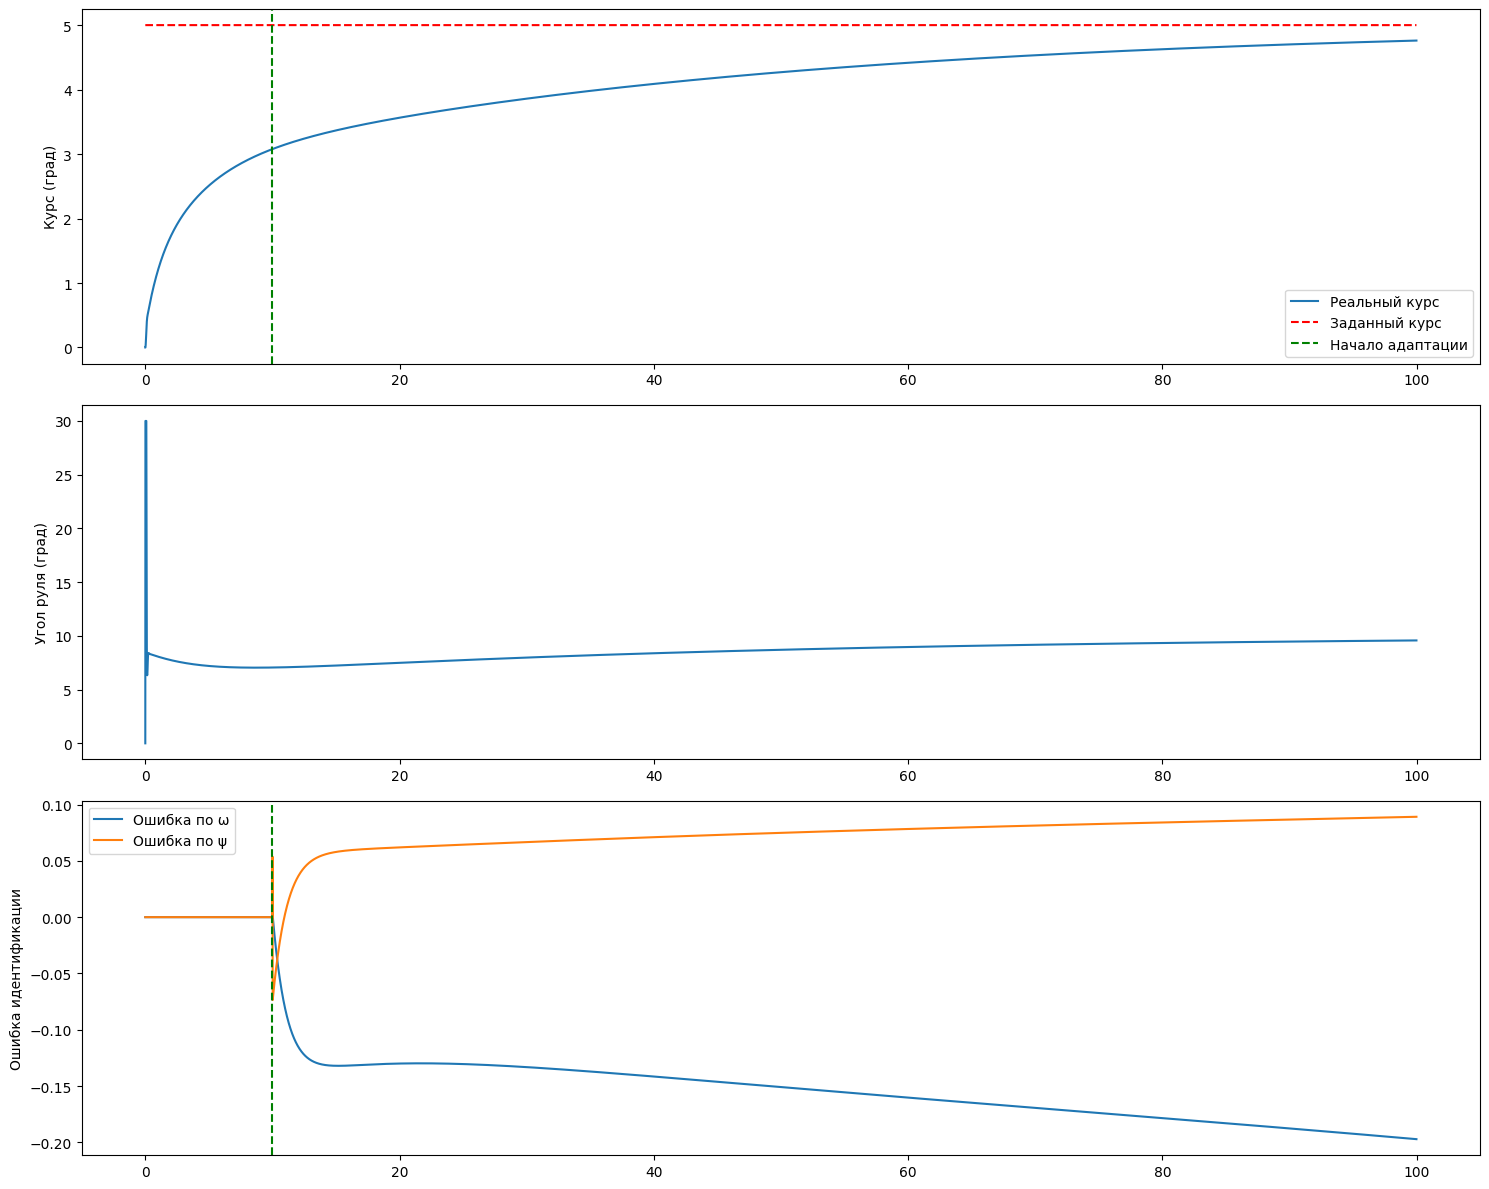

Оцененные параметры:
A =
 [[ 0.02246951  0.99983868]
 [-0.11068523 -0.99986876]]
B = [0.02142122 0.08917484]

Оцененные физические параметры:
K = 0.8057
T1 = 7.8881
T2 = 1.1454


In [ ]:
#Инициализация
ship_real = Ship(T0_real, T1_real, T2_real, K_real)
pid = PIDController(Kp, Ki, Kd)
identifier = AdaptiveIdentifier(gamma, nu0)

autopilot_launch(ship_real, pid, identifier)

Аналитический подбор параметров ПИД

In [ ]:
from scipy.optimize import minimize

T0, T1, T2, K = 4.0, 1.0, 6.0, 0.25
dt = 0.1
t = np.arange(0, 100, dt)
psi_ref = np.deg2rad(5) # Задание курса 5 градусов

def simulate_pid(Kp, Ki, Kd, ship, t, psi_ref):
    pid = PIDController(Kp, Ki, Kd)
    psi = np.zeros_like(t)
    delta = np.zeros_like(t)
    error = np.zeros_like(t)

    # Инициализация начальных условий
    psi[0] = ship.psi
    ship.prev_time = t[0]  # Важно инициализировать время

    for i in range(1, len(t)):
        # Вычисление ошибки
        error[i] = psi_ref - psi[i-1]

        # Вычисление управления
        dt_step = t[i] - t[i-1]
        u = pid.compute(error[i], dt_step)

        # Применение управления к судну
        current_psi, _ = ship.update(u, t[i])
        psi[i] = current_psi
        delta[i] = u

    return psi, delta, error

def analytical_pid(T0, T1, T2, K):
    """Аналитический расчет параметров ПИД по формулам Льюна"""
    alpha, beta, gamma = 0.6, 0.5, 0.125
    Kp = alpha * (T1 + T2) / (K * T0)
    Ki = beta / K
    Kd = gamma * (T1 + T2) / K
    return np.array([Kp, Ki, Kd])

def pid_cost(params):
    """Функция стоимости для оптимизации ПИД-регулятора"""
    Kp, Ki, Kd = params
    cost = 0.0
    rho = 0.1  # Весовой коэффициент для управления

    # Создаем новую модель судна для каждого расчета
    ship = Ship(T0, T1, T2, K)

    # Запускаем моделирование
    psi, delta, error = simulate_pid(Kp, Ki, Kd, ship, t, psi_ref)

    # Вычисляем интегральный критерий
    for i in range(1, len(t)):
        # ITAE-критерий (взвешенная по времени ошибка)
        cost += t[i] * abs(error[i]) * dt

        # Штраф за использование руля
        cost += rho * delta[i]**2 * dt

        # Штраф за перерегулирование (>20%)
        if psi[i] > psi_ref * 1.2:
            cost += 10.0 * abs(psi[i] - psi_ref) * dt

    # Регуляризация для предотвращения больших коэффициентов
    cost += 0.001 * (Kp**2 + Ki**2 + Kd**2)

    return cost

def optimize_pid(initial_params):
    """Функция оптимизации ПИД-параметров"""
    # Ограничения на параметры регулятора
    bounds = [(0.1, 20), (0.01, 5), (0.1, 10)]

    # Минимизация функции стоимости
    result = minimize(
        pid_cost,
        initial_params,
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 100, 'disp': True}
    )
    return result

In [ ]:
initial_params = analytical_pid(T0, T1, T2, K)
initial_params

array([4.2, 2. , 3.5])

In [ ]:
optimized_params = optimize_pid(initial_params)
optimized_params.x

array([6.11217287, 5.        , 0.1       ])

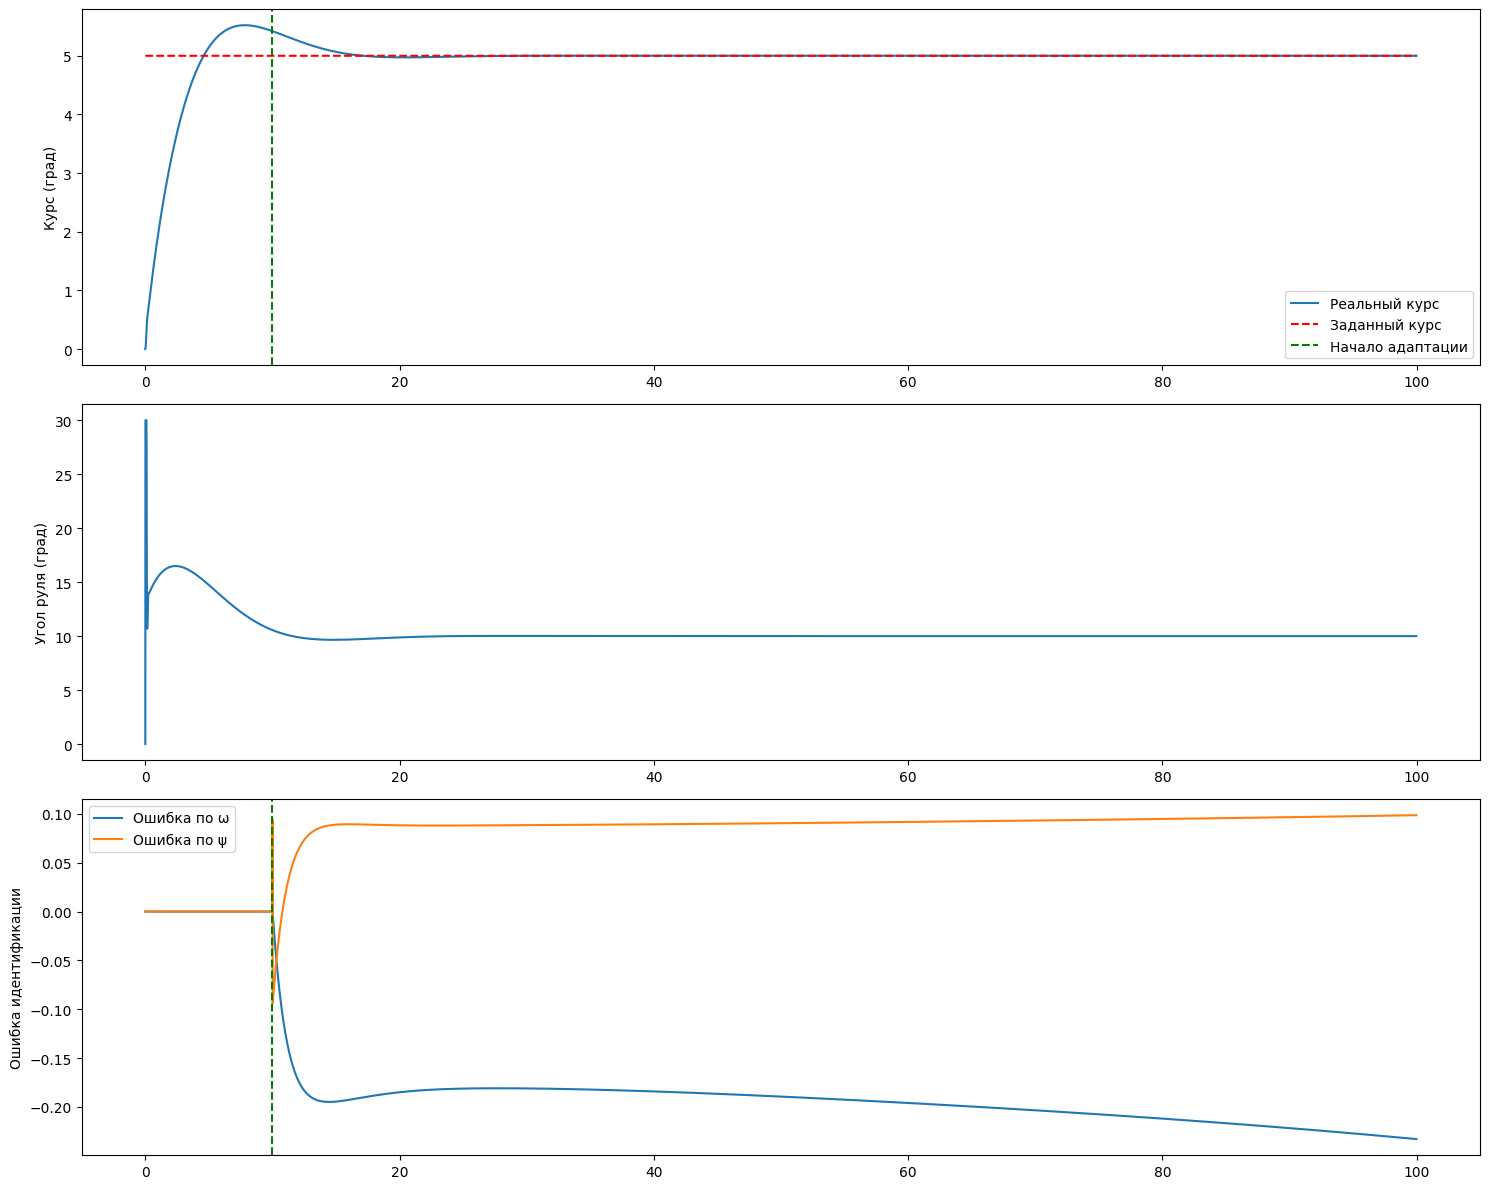

Оцененные параметры:
A =
 [[ 0.03513703  0.99935028]
 [-0.11610079 -0.99960945]]
B = [0.03081981 0.08419312]

Оцененные физические параметры:
K = 0.7252
T1 = 7.4544
T2 = 1.1555


In [ ]:
#Kp, Ki, Kd = optimized_params.x
Kp, Ki, Kd  = 4.2, 2. , 3.5
ship_real = Ship(T0_real, T1_real, T2_real, K_real)
pid = PIDController(Kp, Ki, Kd)
identifier = AdaptiveIdentifier(gamma, nu0)

autopilot_launch(ship_real, pid, identifier)

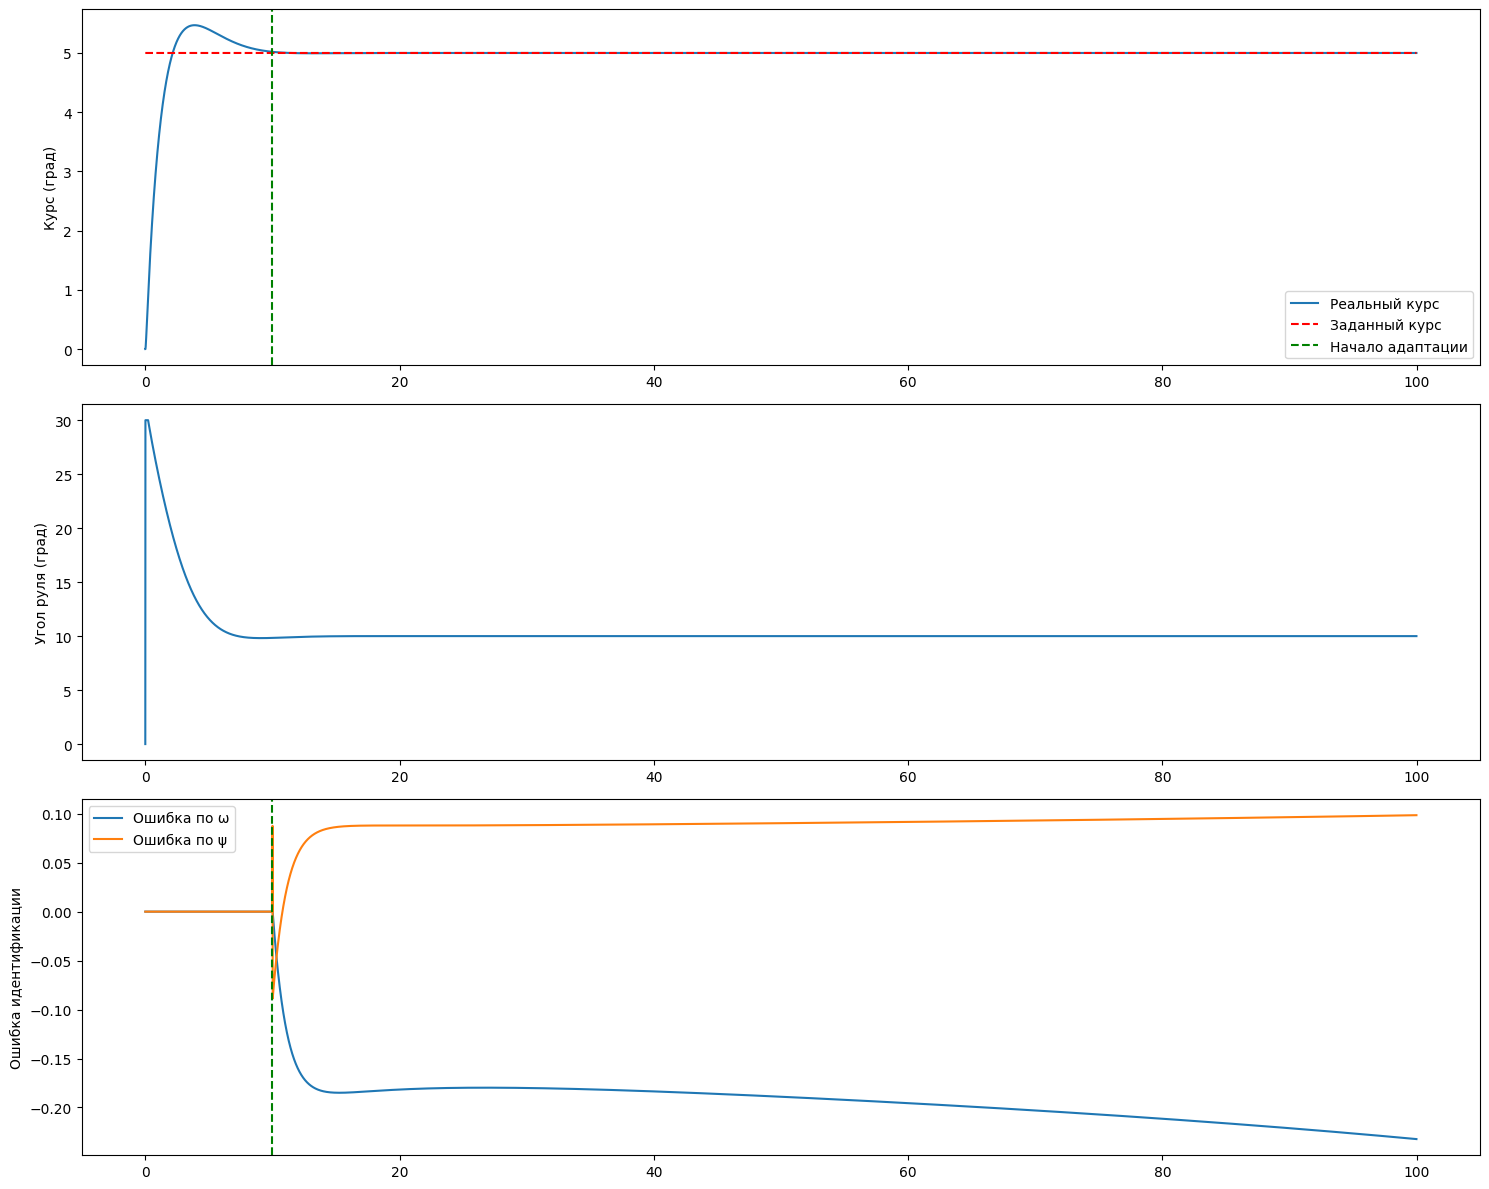

Оцененные параметры:
A =
 [[ 0.03466638  0.99936737]
 [-0.11594751 -0.99962993]]
B = [0.0306296  0.08444513]

Оцененные физические параметры:
K = 0.7283
T1 = 7.4663
T2 = 1.1551


In [ ]:
Kp, Ki, Kd  = 6.11217287, 5, 0.1
ship_real = Ship(T0_real, T1_real, T2_real, K_real)
pid = PIDController(Kp, Ki, Kd)
identifier = AdaptiveIdentifier(gamma, nu0)

autopilot_launch(ship_real, pid, identifier)